# Sensitivity analysis in the finite approximation to the IBP
These results should be the same as in the LRVB notebook 

The difference being that here, functions are written using the VB library

In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import time

import valez_finite_VI_lib as vi
import LRVB_lib as lrvb
import generic_optimization_lib as packing

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')
from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam


### Generate data

In [2]:
np.random.seed(12321)

alpha = 10 # IBP parameter

num_samples = 50 # sample size
D = 2 # dimension

sigma_a = 3.0 ** 2

sigma_eps = 1.0 ** 2 # variance of noise

k_inf = 3 # take to be large for a good approximation to the IBP

# generate data
pi, Z, A, X = vi.generate_data(num_samples, D, k_inf, sigma_a, sigma_eps, alpha)
   

### Initialize variational parameters

In [3]:
k_approx = k_inf # variational truncation

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, D, k_approx)

# define vb model -- vb_model is a class defined using the VB library
vb_model = vi.set_ibp_vb_model(num_samples, D, k_approx)

# initialize parameters
vb_model['phi'].set_vector(np.hstack([np.ravel(phi_mu_init.T), phi_var_init]))
vb_model['pi'].set_vector(np.ravel(tau_init))
vb_model['nu'].set_vector(np.ravel(nu_init))

# consolidate hyper parameters
hyper_params = ModelParamsDict('hyper_params')
hyper_params.push_param(ScalarParam('alpha', lb = 0.0))
hyper_params.push_param(ScalarParam('var_a', lb = 0.0))
hyper_params.push_param(ScalarParam('var_eps', lb = 0.0))

hyper_params['alpha'].set(alpha)
hyper_params['var_a'].set(sigma_a)
hyper_params['var_eps'].set(sigma_eps)

data_set = lrvb.DataSetII(X, vb_model, hyper_params)

In [4]:
# just checking some things about vb_model

print('vb_model[phi] is an array of normals; \neach component has a mean, and each row has a common variance')
print(vb_model['phi'].mean.get())
print(vb_model['phi'].info.get(), '\n')
assert np.all(phi_mu_init.T == vb_model['phi'].e())

print('vb_model[pi] is an array where each row is dirichlet \nwe can get its \
dirchlet parameter tau, and we can get its mean')
print(vb_model['pi'].alpha.get())
print(vb_model['pi'].e(), '\n')
assert np.all(tau_init == vb_model['pi'].alpha.get())

print('vb_model[pi] is an ArrayParam class where each element is constrained to be between 0 and 1')
print(vb_model['nu'].get())
assert np.all(nu_init == vb_model['nu'].get())

vb_model[phi] is an array of normals; 
each component has a mean, and each row has a common variance
[[-0.54418815 -0.77955895]
 [ 1.02570899 -1.90273117]
 [ 1.39126501  0.50792404]]
[ 1.  1.  1.] 

vb_model[pi] is an array where each row is dirichlet 
we can get its dirchlet parameter tau, and we can get its mean
[[ 0.72856094  1.6083226 ]
 [ 1.08473534  1.83491632]
 [ 1.38764972  1.33819602]]
[[ 0.31176605  0.68823395]
 [ 0.37152903  0.62847097]
 [ 0.50907126  0.49092874]] 

vb_model[pi] is an ArrayParam class where each element is constrained to be between 0 and 1
[[ 0.59089984  0.7063214   0.05096026]
 [ 0.13476919  0.94421252  0.70723293]
 [ 0.47378857  0.07489823  0.67988423]
 [ 0.14472992  0.12254821  0.4154281 ]
 [ 0.37648902  0.62800588  0.78534694]
 [ 0.22127982  0.65387899  0.39318878]
 [ 0.03687826  0.29075535  0.78494601]
 [ 0.58098826  0.65236822  0.35867063]
 [ 0.58825708  0.73571513  0.60243071]
 [ 0.3704987   0.24346172  0.08021721]
 [ 0.30788706  0.01019241  0.5201123

### plot the data

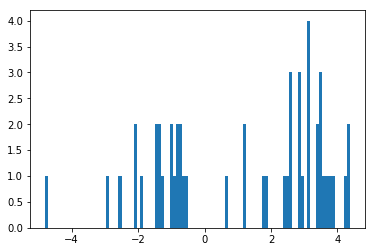

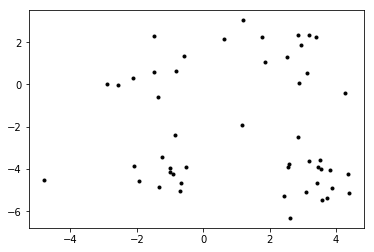

In [5]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

### Run CAVI

In [6]:
# Parameters approximating the true distribution

tau_true = np.zeros_like(tau_init)
tau_true_scale = 15.
tau_true[:, 0] = deepcopy(pi) * tau_true_scale
tau_true[:, 1] = tau_true_scale

nu_true = np.zeros_like(nu_init)
nu_true[Z == 1] = 0.999
nu_true[Z == 0] = 0.001

phi_mu_true = np.zeros_like(phi_mu_init)
phi_mu_true[:] = A.transpose()
phi_var_true = np.zeros_like(phi_var_init)
phi_var_true[:] = 0.01

params_true = packing.pack_params(deepcopy(tau_true), deepcopy(phi_mu_true),
                                  deepcopy(phi_var_true), deepcopy(nu_true))

In [7]:
true_init = False
if true_init:
    vb_model['phi'].set_vector(np.hstack([np.ravel(phi_mu_true.T), phi_var_true]))
    vb_model['pi'].set_vector(np.ravel(tau_true))
    vb_model['nu'].set_vector(np.ravel(nu_true))
    tau, phi_mu, phi_var, nu = data_set.unpack_params(vb_model)
else:
    # the random initialization was done above
    tau, phi_mu, phi_var, nu = data_set.unpack_params(vb_model)
    tau, nu, phi_mu, phi_var = data_set.run_cavi(tau, nu, phi_mu, phi_var, max_iter=100, tol=1e-6)

cavi_tau = deepcopy(tau)
cavi_phi_mu = deepcopy(phi_mu)
cavi_phi_var = deepcopy(phi_var)
cavi_nu = deepcopy(nu)

Step 0 objective: 33.86830252608767
Step 10 objective: 0.16855110958805497
Step 20 objective: 7.798693473404228e-05
Step 30 objective: 9.034479298009046e-07
Done with CAVI.


In [8]:
# CAVI can return nu values that are too close to 0 or 1 for the encoding.
nu_tol = 1e-8
cavi_nu_trim = deepcopy(cavi_nu)
cavi_nu_trim[cavi_nu_trim < nu_tol] = nu_tol
cavi_nu_trim[cavi_nu_trim > 1 - nu_tol] = 1 - nu_tol

cavi_params = packing.pack_params(cavi_tau, cavi_phi_mu, cavi_phi_var, cavi_nu_trim)
print(np.all(np.isfinite(cavi_params)))

vb_model.set_free(cavi_params)
cavi_resid = data_set.x - data_set.get_prediction(vb_model)

True


### Run Newton trust region

In [9]:
data_set.trace.reset()
vb_opt = data_set.run_newton_tr(cavi_params, maxiter=50, gtol=1e-2)
vb_model.set_free(vb_opt.x)

Step 0 objective: 1837.9196544859944
Step 10 objective: -324.11662736849064
Optimization terminated successfully.
         Current function value: -324.116627
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 0
Done with Newton trust region.


In [10]:
print ('CAVI:')
print (cavi_phi_mu.transpose())
print (cavi_tau)

print ('Full TR:')
print (vb_model['phi'].mean.get())
print (vb_model['pi'].alpha.get())


print ('Truth:')
print (A)


CAVI:
[[-1.38893495 -4.01490838]
 [ 2.85744278 -2.84252141]
 [ 2.11953515  1.9052959 ]]
[[ 26.35900588  27.97432745]
 [ 22.33044711  32.00288622]
 [ 25.4225489   28.91078444]]
Full TR:
[[-1.38863083 -4.01457026]
 [ 2.85753707 -2.84241839]
 [ 2.11952604  1.90528118]]
[[ 26.35908043  27.97425364]
 [ 22.33639699  32.01067585]
 [ 25.4190305   28.918397  ]]
Truth:
[[-1.51981911  1.36489297]
 [ 0.07076695 -5.93156821]
 [ 4.53218492  0.19643952]]


Cavi residuals: 252.98777441871138    Trust residuals: 63.33092676773032      True residuals: 78.48308573612925


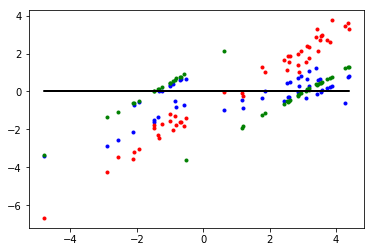

In [11]:
tr_resid = data_set.x - data_set.get_prediction(vb_model)
true_resid = data_set.x - np.matmul(Z, A)

plt.figure()
col = 0
plt.plot(data_set.x[:, col], tr_resid[:, col], '.b')
plt.plot(data_set.x[:, col], cavi_resid[:, col], '.r')
plt.plot(data_set.x[:, col], true_resid[:, col], '.g')
plt.plot(data_set.x[:, col], np.full_like(data_set.x[:, col], 0.), 'k')

print('Cavi residuals: {}    Trust residuals: {}      True residuals: {}'.format(
       np.sum(np.abs(cavi_resid)), np.sum(np.abs(tr_resid)), np.sum(np.abs(true_resid))))


In [12]:
# Examining functional sensitivity

In [13]:
import functional_perturbation_lib as func_pert

In [14]:
def u_pert(x): 
    return 0.0 * x
vb_model_pert = deepcopy(vb_model)

In [15]:
data_set_perturb  = func_pert.FunctionalPerturbation(X, vb_model_pert, hyper_params, u = u_pert)
vb_opt_pert = data_set_perturb.run_newton_tr(vb_model_pert.get_free(), n_grid = 100, maxiter=10, gtol=1e-6)
vb_model_pert.set_free(vb_opt_pert.x)

Step 0 objective: -327.7285457814685
Optimization terminated successfully.
         Current function value: -327.728561
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Done with Newton trust region.


In [16]:
print (vb_model_pert['phi'].mean.get())
print (vb_model_pert['pi'].alpha.get())

[[-1.38893479 -4.01490832]
 [ 2.85744262 -2.84252138]
 [ 2.11953524  1.9052959 ]]
[[ 26.35900574  27.9743276 ]
 [ 22.33044713  32.00288585]
 [ 25.42254759  28.91078616]]


In [ ]:
[[-1.38863083 -4.01457026]
 [ 2.85753707 -2.84241839]
 [ 2.11952604  1.90528118]]
[[ 26.35908043  27.97425364]
 [ 22.33639699  32.01067585]
 [ 25.4190305   28.918397  ]]

In [ ]:
# Compute prior sensitivity, eq. 18 in the paper
moment_sensitivity = data_set.local_prior_sensitivity()

#print(moment_sensitivity)
#np.shape(moment_sensitivity)

In [ ]:
# The third column is sigma_eps.
sigma_eps_col = 2
e_log_pi_sigma_eps_sens, e_mu_sigma_eps_sens = \
    packing.unpack_moments(moment_sensitivity[:, sigma_eps_col], k_approx, D)
    
print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

In [ ]:
"""# Perturb and re-rerun to check the sensitivity.

epsilon = 1e-1
data_set_perturb = lrvb.DataSet(X, k_approx, alpha, sigma_eps + epsilon, sigma_a)
data_set_perturb.trace.print_every = 1
vb_opt_perturb = data_set_perturb.run_newton_tr(vb_opt.x)"""

In [ ]:
"""e_log_pi, e_mu = data_set.get_moments(tr_params)
e_log_pi_perturb, e_mu_perturb = data_set.get_moments(vb_opt_perturb.x)

print('Measured sensitivity of e_mu to sigma_eps:')
print((e_mu_perturb - e_mu) / epsilon)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

print('Measured sensitivity of e_log_pi to sigma_eps:')
print((e_log_pi_perturb - e_log_pi) / epsilon)

print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)
"""

In [ ]:
data_set.influence_function_pi(0.8, 1)

In [ ]:
# plot influence function

n_ticks = 100
y = np.zeros((n_ticks, k_approx))

post_pi = 0 # which pi you're looking at in the posterior

theta = np.linspace(0.001,0.999,n_ticks)

for k in range(k_approx):  
    for i in range(n_ticks): 
        y[i, k] = data_set.influence_function_pi(theta[i], k)[post_pi]
        
    plt.plot(theta, y[:,k])
    plt.xlabel('theta')
    plt.title('Marginal Influence on E[log pi' + str(post_pi) + '],\nwith prior perturbation on pi_' + str(k))
    plt.show()

plt.plot(theta, np.sum(y,1))
plt.xlabel('theta')
plt.title('Total Influence on E[log pi' + str(post_pi) + ']')
plt.show()


In [ ]:
vi.compute_elboII(X, vb_model, hyper_params)